 <h1 align="center">Find a car Park using CNN</h1>

 <h3 align="center">Authors: Noa Aizer & Ido Shapira & Shay Leyzerovich</h3>   

In this project we propose to develop a model for identifying whether there is free space in theparking lot image, or whether the parking is full using CNN.

## Code & Explanations:

### Import all the necessary libraries:
We have used Python libraries:
- tensorflow v1
- sklearn

In [1]:
import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
# import tensorflow as tf
import cv2
import os
from tqdm import tqdm
import numpy as np
import random as rn

from __future__ import division, print_function, absolute_import

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn import metrics


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

rs = 42 # random seed

### fix random seed:

In [2]:
np.random.seed(rs)
rn.seed(rs)
tf.set_random_seed(rs)

### import the data:

In [3]:
X = []
Z = []
IMG_SIZE=160

FREE_DIR='C:/Users/USER/Desktop/Ariel University/שנה ג סמסטר א/למידה עמוקה ועיבוד שפות טבעיות/project/data/Free_part'
FULL_DIR='C:/Users/USER/Desktop/Ariel University/שנה ג סמסטר א/למידה עמוקה ועיבוד שפות טבעיות/project/data/Full_part'

In [4]:
def make_train_data(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR,img)
        img = plt.imread(path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        np_img=np.asarray(img)
        X.append(np_img)
        Z.append(str(label))

In [5]:
# make 'Full' data
make_train_data('Full',FULL_DIR)
print(len(X))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 366/366 [00:10<00:00, 34.92it/s]

366


In [6]:
# make 'Free' data
make_train_data('Free',FREE_DIR)
print(len(X))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 356/356 [00:09<00:00, 35.71it/s]

722


### The description of the data:

1. Number of instances: 722

2. Number of attributes: 150 * 150 * 3 = 67500

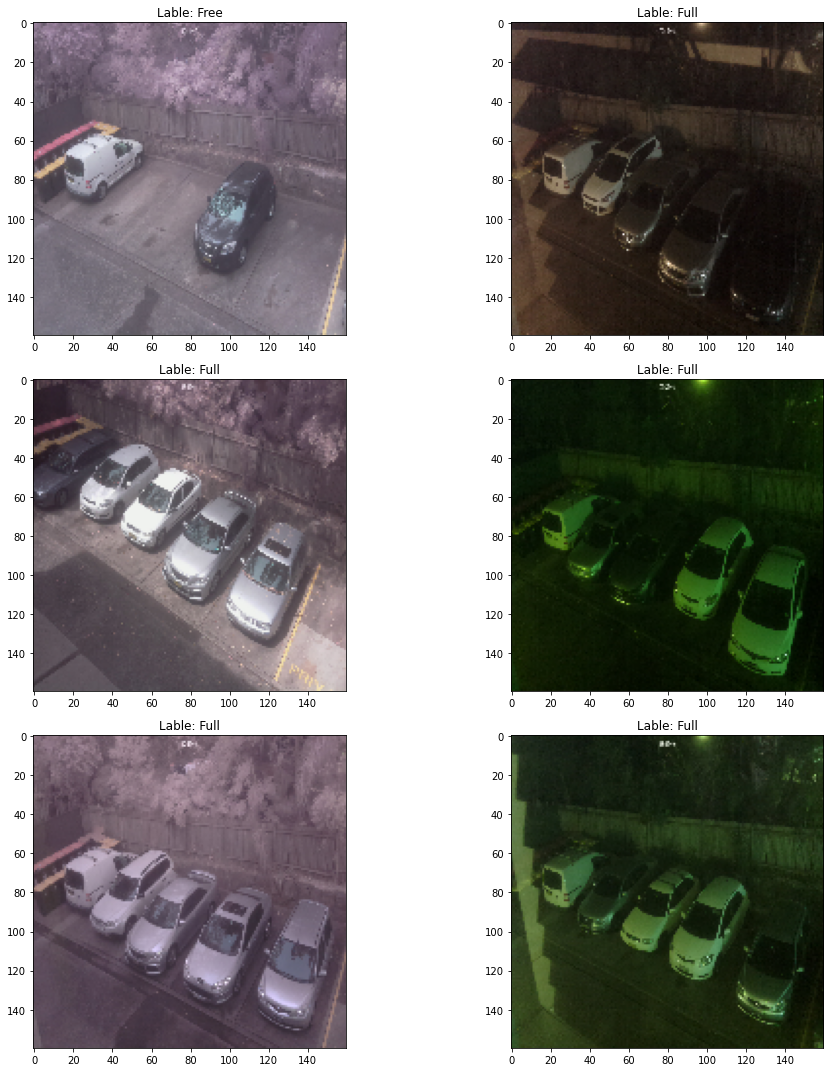

In [7]:
# check some image
fig,ax=plt.subplots(3,2)
fig.set_size_inches(15,15)
for i in range(3):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Lable: '+Z[l])
        
plt.tight_layout()

### Label encoding of the target:
'Full' = 0

'Free' = 1

In [8]:
Y = np.array(Z)
Y = np.where(Y=='Full', 0, Y)
Y = np.where(Y=='Free', 1, Y)
Y = Y.astype('int32')

### normalization and flatten the images:

In [9]:
X = np.array([cv2.normalize(X[i], None, 0, 255, cv2.NORM_MINMAX) for i in range(len(X))]) # normalization
X=np.array(X)/255
X = X.flatten().reshape(len(X), (IMG_SIZE ** 2) * 3) # 3 is because it is RGB image 
# X = X.flatten().reshape(len(X), (IMG_SIZE ** 2)) 

#### our dataset:

In [10]:
df = pd.DataFrame(data=X)
df

,0,1,2,3,4,5,6,7,8,9,...,76790,76791,76792,76793,76794,76795,76796,76797,76798,76799
0,0.223529,0.160784,0.235294,0.211765,0.164706,0.223529,0.223529,0.168627,0.215686,0.200000,...,0.486275,0.396078,0.541176,0.509804,0.450980,0.556863,0.549020,0.470588,0.564706,0.556863
1,0.227451,0.149020,0.219608,0.223529,0.152941,0.207843,0.231373,0.160784,0.211765,0.239216,...,0.486275,0.431373,0.482353,0.498039,0.458824,0.521569,0.525490,0.486275,0.541176,0.552941
2,0.133333,0.176471,0.125490,0.160784,0.203922,0.125490,0.133333,0.188235,0.117647,0.137255,...,0.329412,0.247059,0.533333,0.356863,0.258824,0.545098,0.376471,0.254902,0.560784,0.376471
3,0.219608,0.160784,0.200000,0.227451,0.168627,0.203922,0.219608,0.152941,0.215686,0.231373,...,0.450980,0.435294,0.501961,0.478431,0.454902,0.525490,0.517647,0.462745,0.521569,0.521569
4,0.176471,0.176471,0.215686,0.200000,0.188235,0.211765,0.188235,0.180392,0.192157,0.215686,...,0.435294,0.419608,0.529412,0.525490,0.415686,0.521569,0.521569,0.439216,0.564706,0.564706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,0.117647,0.152941,0.156863,0.156863,0.200000,0.149020,0.125490,0.172549,0.121569,0.145098,...,0.129412,0.313725,0.560784,0.447059,0.435294,0.858824,0.619608,0.568627,0.956863,0.725490
718,0.082353,0.031373,0.047059,0.086275,0.031373,0.043137,0.125490,0.070588,0.082353,0.121569,...,0.431373,0.705882,0.792157,0.831373,0.458824,0.454902,0.490196,0.439216,0.439216,0.462745
719,0.078431,0.027451,0.062745,0.082353,0.031373,0.066667,0.180392,0.082353,0.090196,0.133333,...,0.439216,0.733333,0.792157,0.831373,0.462745,0.454902,0.513725,0.447059,0.427451,0.490196
720,0.101961,0.039216,0.058824,0.094118,0.039216,0.062745,0.262745,0.141176,0.180392,0.200000,...,0.337255,0.678431,0.725490,0.800000,0.443137,0.454902,0.490196,0.439216,0.439216,0.478431


We can see that the size of an image is 150 \* 150 \* 3 = 67500 that later it would be our featrues in our models.

In [11]:
X.shape

(722, 76800)

### Train-Test Split:

In [12]:
# separate data
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.20,random_state=rs, shuffle=True)

freqs = pd.DataFrame({"Training dataset": [(y_train == 1).sum(),(y_train == 0).sum()],
                      "Test dataset": [(y_test == 1).sum(),(y_test == 0).sum()],
                      "Total": [(y_train == 1).sum()+(y_test == 1).sum(),(y_train == 0).sum()+(y_test == 0).sum()]},
                     index=["Free", "Full"])
freqs[["Training dataset", "Test dataset", "Total"]]

,Training dataset,Test dataset,Total
Free,289,67,356
Full,288,78,366


We'll build a classifier with two classes: "full",
so we create the according labels.

In [13]:
labels_train = (np.arange(2) == y_train[:,None]).astype(np.float32)
labels_test = (np.arange(2) == y_test[:,None]).astype(np.float32)

In [14]:
def statistics(confusion):
    TP = sess.run(confusion[1, 1])
    TN = sess.run(confusion[0, 0])
    FP = sess.run(confusion[0, 1])
    FN = sess.run(confusion[1, 0])
    print('True Positives (TP):',TP)
    print('True Negatives (TN):',TN)
    print('False Positives (FP):',FP)
    print('False Negarives (FN):',FN)
    print('Classification Accuracy:',(TP + TN) / float(TP + TN + FP + FN))
    precision = TN / float(TN + FP)
    print('Precision:',precision)
    recall = TP / float(TP + FN)
    print('Recall:', recall)
    print('f-score:', 2 * precision * recall / (precision + recall))

### Begin building the CNN model using tensorflow:

Training Parameters

In [15]:
learning_rate = 0.0003
num_steps = 260
batch_size = 25
display_step = 10
channels = 3 # RGB

Network Parameters

In [16]:
num_input = IMG_SIZE * IMG_SIZE * channels
num_classes = 2
dropout = 0.75 # Dropout, probability to keep units

tf Graph input

In [17]:
tf.compat.v1.disable_eager_execution()

X = tf.placeholder(tf.float32, [None, num_input])
Y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)

Store layers weight & bias

In [18]:

weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, channels, 32])),
    # 3x3 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32 , 64])),
    # 3x3 conv, 32 inputs, 64 outputs
    'wc3': tf.Variable(tf.random_normal([3, 3, 64 , 96])),
    # fully connected, 10*10*96 inputs, 512 outputs
    'wd1': tf.Variable(tf.random_normal([20*20*96 , 1024])),
    # 1024 inputs, 2 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bc3': tf.Variable(tf.random_normal([96])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

Create some wrappers for simplicity

In [19]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

Create model

In [20]:
def conv_net(x, weights, biases, dropout):
    # Reshape to match picture format [Height x Width x Channel]
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
    x = tf.reshape(x, shape=[-1, IMG_SIZE, IMG_SIZE, channels])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    
    # Convolution Layer
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # Max Pooling (down-sampling)
    conv3 = maxpool2d(conv3, k=2)

    # Fully connected layer
    # Reshape conv3 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

Construct model

In [21]:
logits = conv_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Define loss and optimizer

In [22]:
# loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

Evaluate model

In [23]:
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Initialize the variables (i.e. assign their default value)

In [24]:
init = tf.global_variables_initializer()

Start training

In [25]:
# Define the variable that saves the result
loss_trace = []
train_acc = []
test_acc = []

In [26]:
with tf.Session() as sess:
    # Run the initializer
    sess.run(init)
    for step in range(1, num_steps+1):        
        # Generate random batch index
        batch_index = np.random.choice(len(X_train), size=batch_size)
        batch_x = X_train[batch_index]
        batch_y = labels_train[batch_index]

        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: 0.8})
        
        # Calculate batch loss and accuracy
        loss, temp_train_acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x, Y: batch_y, keep_prob: 1.0})
        temp_test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: labels_test, keep_prob: 1.0})
        if step % display_step == 0 or step == 1:
            print("Step " + str(step) + ", Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(temp_train_acc) + ", Test Accuracy= " + \
                 "{:.3f}".format(temp_test_acc))
            
        # recode the result
        loss_trace.append(loss)
        train_acc.append(temp_train_acc)
        test_acc.append(temp_test_acc)
        

    print("Optimization Finished!")
    
    # Calculate accuracy
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: X_test,
                                      Y: labels_test,
                                      keep_prob: 1.0}))

Step 1, Loss= 371203.1250, Training Accuracy= 0.600, Test Accuracy= 0.455
Step 10, Loss= 252474.0156, Training Accuracy= 0.760, Test Accuracy= 0.683
Step 20, Loss= 276638.8438, Training Accuracy= 0.560, Test Accuracy= 0.600
Step 30, Loss= 106897.0391, Training Accuracy= 0.880, Test Accuracy= 0.738
Step 40, Loss= 111119.6719, Training Accuracy= 0.840, Test Accuracy= 0.772
Step 50, Loss= 222924.5938, Training Accuracy= 0.560, Test Accuracy= 0.779
Step 60, Loss= 135150.0469, Training Accuracy= 0.800, Test Accuracy= 0.779
Step 70, Loss= 73195.0312, Training Accuracy= 0.840, Test Accuracy= 0.800
Step 80, Loss= 38052.8789, Training Accuracy= 0.920, Test Accuracy= 0.828
Step 90, Loss= 65155.8711, Training Accuracy= 0.840, Test Accuracy= 0.793
Step 100, Loss= 74281.6562, Training Accuracy= 0.800, Test Accuracy= 0.800
Step 110, Loss= 84454.7969, Training Accuracy= 0.800, Test Accuracy= 0.828
Step 120, Loss= 28922.5566, Training Accuracy= 0.920, Test Accuracy= 0.862
Step 130, Loss= 71090.1172, T

### Visualization of the loss function results:

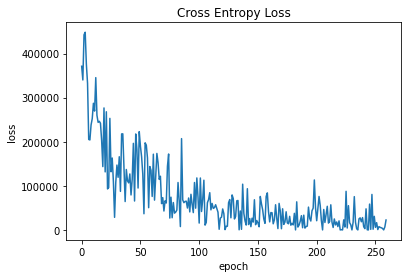

In [27]:
plt.plot(loss_trace)
plt.title('Cross Entropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

We can see that the loss value reduce during the train, there's a graph that shows that.

In [28]:
# The model prediction
y_predictions = sess.run(prediction, feed_dict={X: X_test, Y: labels_test})

RuntimeError: Attempted to use a closed Session.

In [ ]:
tf.compat.v1.math.confusion_matrix
confusion = tf.math.confusion_matrix(y_test, y_predictions, num_classes=2, dtype=tf.int32)
print(sess.run(confusion))

In [ ]:
statistics(confusion)

The results indicate that the model could not recognize a lot of free parking spot because of the recall but when it did the precision was high.

In [ ]:
# tf.compat.v1.disable_eager_execution()

# x = tf.placeholder(tf.float32, shape=[None, X_train.shape[1]])
# y_ = tf.placeholder(tf.float32, shape=[None, 2])

# W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 3, 32], stddev=0.1))
# b_conv1 = tf.Variable(tf.constant(0.1, shape=[32]))
# x_image = tf.reshape(x, [-1,IMG_SIZE,IMG_SIZE,3]) #if we had RGB, we would have 3 channels

# h_conv1 = tf.nn.relu(tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)
# h_pool1 = tf.nn.max_pool(h_conv1, ksize=[3, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1))
# b_conv2 = tf.Variable(tf.constant(0.1, shape=[64]))

# h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2)
# h_pool2 = tf.nn.max_pool(h_conv2, ksize=[3, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# h_pool2_flat = tf.reshape(h_pool2, [-1, 3 * 40*40*64])
# W_fc1 = tf.Variable(tf.truncated_normal([3 * 40*40*64, 1024], stddev=0.1))
# b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))

# h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# keep_prob = tf.placeholder(tf.float32)
# h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# W_fc2 = tf.Variable(tf.truncated_normal([1024, 2], stddev=0.1))
# b_fc2 = tf.Variable(tf.constant(0.1, shape=[2]))

# y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

In [ ]:
# batch_size = 30
# learning_rate = 1e-4

In [ ]:
# cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
# train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy) #uses moving averages momentum

# correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# predict = tf.argmax(y_conv, axis=1) # our

# sess = tf.InteractiveSession()
# sess.run(tf.global_variables_initializer())

# for i in range(200):
#     # Generate random batch index
#     batch_index = np.random.choice(len(X_train), size=batch_size)
#     batch_train_X = X_train[batch_index]
#     batch_train_y = np.matrix(labels_train[batch_index]).T
#     if i%10 == 0:
# #         for i in range(batch_train_X.shape[0]):
# #             train_accuracy = accuracy.eval(feed_dict={x: batch_train_X[i], y_: batch_train_y[i], keep_prob: 1.0})
#         train_accuracy = np.mean(np.argmax(labels_train, axis=1) == sess.run(predict, feed_dict={x: X_train, y_: labels_train}))
#         print("step %d, training accuracy %g"%(i, train_accuracy))
#     train_step.run(feed_dict={x: batch_train_X, y_: batch_train_y, keep_prob: 0.5})

# print("test accuracy %g"%accuracy.eval(feed_dict={x: X_test, y_: labels_test, keep_prob: 1.0}))

# InteractiveSession.close()